In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
csv = '/content/drive/My Drive/tweets/cleaned1.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 798109 entries, 1334467 to 879542
Data columns (total 2 columns):
text      798109 non-null object
target    798109 non-null int64
dtypes: int64(1), object(1)
memory usage: 18.3+ MB


In [0]:
my_df.head()

,text,target
1334467,now following on recommendation must be good g...,1
1492580,apologies for being slow in realising but just...,1
22788,your so rags,0
1205338,you re very welcome wish could do more,1
1138907,everyone check out,1


In [0]:
x = my_df.text
y = my_df.target

In [0]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)


In [0]:
print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 782146 entries with 49.94% negative, 50.06% positive
Validation set has total 7981 entries with 49.76% negative, 50.24% positive
Test set has total 7982 entries with 50.04% negative, 49.96% positive


## Aritificial Neural Network

My first idea was, if logistic regression is the best performing classifier, then this idea can be extended to neural networks. In terms of its structure, logistic regression can be thought as a neural network with no hidden layer, and just one output node.

### ANN with Tfidf vectorizer

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec1 = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))

In [0]:

tvec1.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [0]:
x_train_tfidf = tvec1.transform(x_train)

In [0]:
x_validation_tfidf = tvec1.transform(x_validation)

In [0]:
seed = 7
np.random.seed(seed)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [0]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            counter=0

The structure of below NN model has 100,000 nodes in the input layer, then 64 nodes in a hidden layer with Relu activation function applied, then finally one output layer with sigmoid activation function applied. There are different types of optimizing techniques for neural networks, and different loss function you can define with the model. Below model uses ADAM optimizing, and binary cross entropy loss.

In [0]:
%%time
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=100000))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 32),
                    epochs=5, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
24443/24442 [==============================] - 720s 29ms/step - loss: 0.4200 - acc: 0.8070 - val_loss: 0.3973 - val_acc: 0.8221
Epoch 2/5
24443/24442 [==============================] - 715s 29ms/step - loss: 0.3636 - acc: 0.8394 - val_loss: 0.4051 - val_acc: 0.8220
Epoch 3/5
24443/24442 [==============================] - 713s 29ms/step - loss: 0.3397 - acc: 0.8536 - val_loss: 0.4172 - val_acc: 0.8186
Epoch 4/5
24443/24442 [==============================] - 714s 29ms/step - loss: 0.3122 - acc: 0.8690 - val_loss: 0.4530 - val_acc: 0.8043
Epoch 5/5
24443/24442 [==============================] - 713s 29ms/step - loss: 0.2852 - acc: 0.8832 - val_loss: 0.4971 - val_acc: 0.7928
CPU times: user 1h 10min 21s, sys: 11min 21s, total: 1h 21min 42s
Wall time: 59min 34s


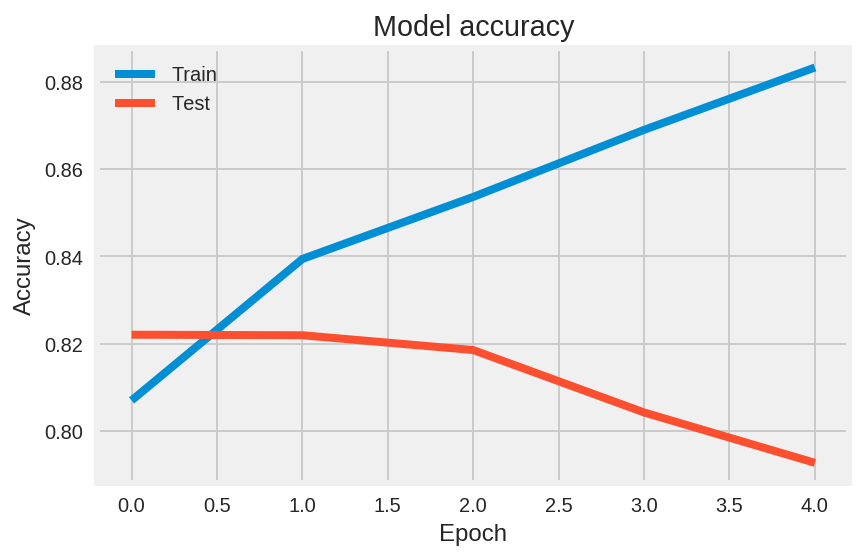

In [39]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Introducing the droppout

In [0]:
model1 = Sequential()
model1.add(Dense(64, activation='relu', input_dim=100000))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 32),
                    epochs=5, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/5
24443/24442 [==============================] - 716s 29ms/step - loss: 0.4211 - acc: 0.8074 - val_loss: 0.3977 - val_acc: 0.8218
Epoch 2/5
24443/24442 [==============================] - 711s 29ms/step - loss: 0.3674 - acc: 0.8383 - val_loss: 0.4049 - val_acc: 0.8199
Epoch 3/5
24443/24442 [==============================] - 721s 29ms/step - loss: 0.3478 - acc: 0.8505 - val_loss: 0.4136 - val_acc: 0.8196
Epoch 4/5
24443/24442 [==============================] - 719s 29ms/step - loss: 0.3336 - acc: 0.8595 - val_loss: 0.4232 - val_acc: 0.8184
Epoch 5/5
24443/24442 [==============================] - 719s 29ms/step - loss: 0.3188 - acc: 0.8691 - val_loss: 0.4395 - val_acc: 0.8157


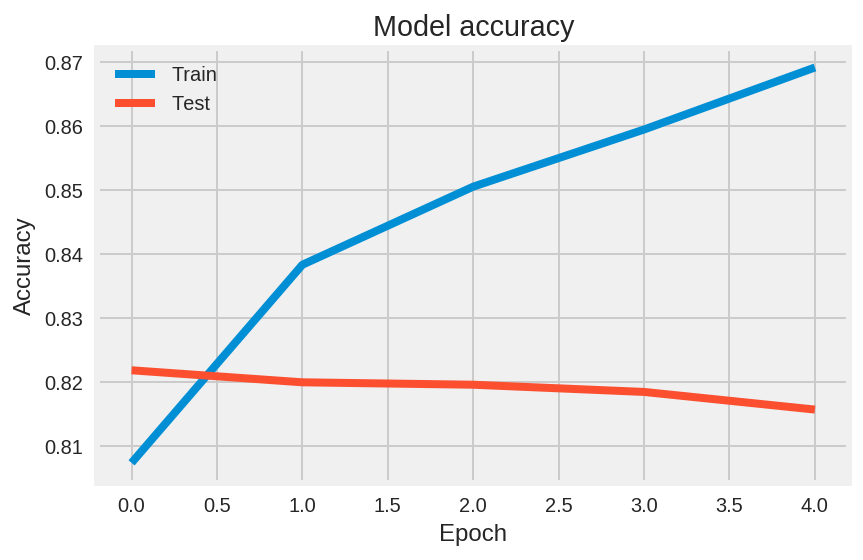

In [40]:
plt.plot(model1.history.history['acc'])
plt.plot(model1.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

shuffeled


In [0]:
def batch_generator_shuffle(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(index)
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            np.random.shuffle(index)
            counter=0

In [0]:
%%time
model_s_1 = Sequential()
model_s_1.add(Dense(64, activation='relu', input_dim=100000))
model_s_1.add(Dropout(0.2))
model_s_1.add(Dense(1, activation='sigmoid'))
model_s_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_s_1.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=5, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/5
24443/24442 [==============================] - 723s 30ms/step - loss: 0.4213 - acc: 0.8069 - val_loss: 0.3976 - val_acc: 0.8221
Epoch 2/5
24443/24442 [==============================] - 722s 30ms/step - loss: 0.3664 - acc: 0.8384 - val_loss: 0.4023 - val_acc: 0.8206
Epoch 3/5
24443/24442 [==============================] - 722s 30ms/step - loss: 0.3473 - acc: 0.8499 - val_loss: 0.4082 - val_acc: 0.8221
Epoch 4/5
24443/24442 [==============================] - 723s 30ms/step - loss: 0.3339 - acc: 0.8583 - val_loss: 0.4213 - val_acc: 0.8189
Epoch 5/5
24443/24442 [==============================] - 722s 30ms/step - loss: 0.3222 - acc: 0.8662 - val_loss: 0.4334 - val_acc: 0.8189
CPU times: user 1h 11min 8s, sys: 11min 20s, total: 1h 22min 28s
Wall time: 1h 11s


As same as the non-shuffled data, both the training accuracy and validation accuracy slightly dropped.


```
# testing learn rate

```


As I was going through the "deeplearning.ai" course by Andrew Ng, he states that the first thing he would try to improve a neural network model is tweaking the learning rate. I decided to follow his advice and try different learning rates with the model. Please note that except for the learning rate, the parameter for 'beta_1', 'beta_2', and 'epsilon' are set to the default values presented by the original paper "ADAM: A Method for Stochastic Optimization" by Kingma and Ba (2015). https://arxiv.org/pdf/1412.6980.pdf




```
# Learning Rate = 0.005!
```



In [0]:
 %%time
import keras
custom_adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_testing_2 = Sequential()
model_testing_2.add(Dense(64, activation='relu', input_dim=100000))
model_testing_2.add(Dense(1, activation='sigmoid'))
model_testing_2.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_testing_2.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=2, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/2
24443/24442 [==============================] - 716s 29ms/step - loss: 0.4223 - acc: 0.8058 - val_loss: 0.4002 - val_acc: 0.8192
Epoch 2/2
24443/24442 [==============================] - 714s 29ms/step - loss: 0.3632 - acc: 0.8394 - val_loss: 0.4037 - val_acc: 0.8187
CPU times: user 28min 4s, sys: 4min 32s, total: 32min 36s
Wall time: 23min 50s




```
# Learning Rate = 0.0005!
```



In [0]:
%%time
custom_adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_testing_3 = Sequential()
model_testing_3.add(Dense(64, activation='relu', input_dim=100000))
model_testing_3.add(Dense(1, activation='sigmoid'))
model_testing_3.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_testing_3.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=2, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/2
24443/24442 [==============================] - 715s 29ms/step - loss: 0.4204 - acc: 0.8082 - val_loss: 0.3978 - val_acc: 0.8225
Epoch 2/2
24443/24442 [==============================] - 715s 29ms/step - loss: 0.3627 - acc: 0.8395 - val_loss: 0.4044 - val_acc: 0.8217
CPU times: user 28min 13s, sys: 4min 31s, total: 32min 44s
Wall time: 23min 50s




```
# Learning Rate = 0.01!
```





In [29]:
%%time
custom_adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_testing_4 = Sequential()
model_testing_4.add(Dense(64, activation='relu', input_dim=100000))
model_testing_4.add(Dense(1, activation='sigmoid'))
model_testing_4.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_testing_4.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=2, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/2
24443/24442 [==============================] - 714s 29ms/step - loss: 0.4247 - acc: 0.8049 - val_loss: 0.4064 - val_acc: 0.8194
Epoch 2/2
24443/24442 [==============================] - 707s 29ms/step - loss: 0.3660 - acc: 0.8389 - val_loss: 0.4067 - val_acc: 0.8177
CPU times: user 27min 55s, sys: 4min 31s, total: 32min 26s
Wall time: 23min 42s




```
# Learning eae 0.1
```



In [30]:
%%time
custom_adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_testing_5 = Sequential()
model_testing_5.add(Dense(64, activation='relu', input_dim=100000))
model_testing_5.add(Dense(1, activation='sigmoid'))
model_testing_5.compile(optimizer=custom_adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_testing_5.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=2, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/2
24443/24442 [==============================] - 707s 29ms/step - loss: 0.4253 - acc: 0.8049 - val_loss: 0.4014 - val_acc: 0.8220
Epoch 2/2
24443/24442 [==============================] - 709s 29ms/step - loss: 0.3663 - acc: 0.8387 - val_loss: 0.4055 - val_acc: 0.8221
CPU times: user 27min 46s, sys: 4min 38s, total: 32min 25s
Wall time: 23min 37s


Having tried four different learning rates (0.0005, 0.005, 0.01, 0.1), none of them outperformed the default learning rate of 0.001.



```
#  increase the number of hidden nodes
```



In [32]:
%%time
model_s_2 = Sequential()
model_s_2.add(Dense(128, activation='relu', input_dim=100000))
model_s_2.add(Dense(1, activation='sigmoid'))
model_s_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_s_2.fit_generator(generator=batch_generator_shuffle(x_train_tfidf, y_train, 32),
                    epochs=2, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/2
24443/24442 [==============================] - 873s 36ms/step - loss: 0.4203 - acc: 0.8070 - val_loss: 0.3951 - val_acc: 0.8218
Epoch 2/2
24443/24442 [==============================] - 882s 36ms/step - loss: 0.3624 - acc: 0.8398 - val_loss: 0.4034 - val_acc: 0.8226
CPU times: user 30min 54s, sys: 6min 57s, total: 37min 51s
Wall time: 29min 15s


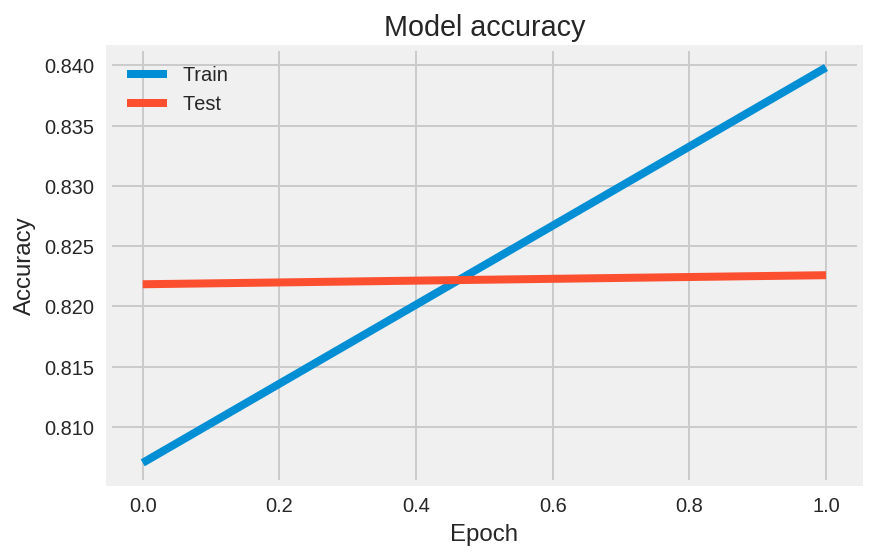

{'acc': [0.807007898781046, 0.8398150728892049],
 'loss': [0.4202990357419638, 0.36234077486121163],
 'val_acc': [0.8218268387420122, 0.8225786242325523],
 'val_loss': [0.3950764931689483, 0.40337070655148294]}

In [35]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

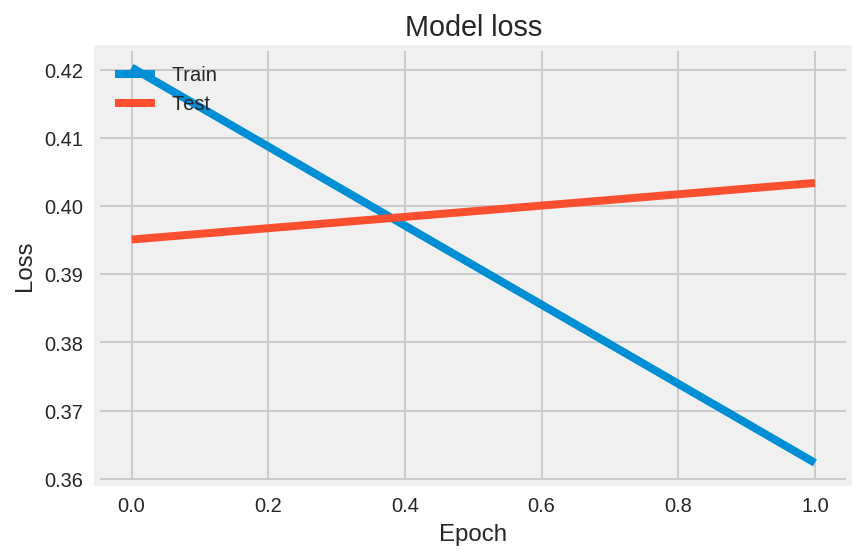

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()